In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout

from keras.datasets import cifar10

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2, random_state=0)

satır, sütun, katman = x_train.shape[1:]

def build_model(hp):
    model = Sequential()

    model.add(Conv2D(filters=hp.Int("filter_1",min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice("kernel_1",values=[3,5]),
                     input_shape=(satır, sütun, katman), 
                     activation="relu"))
              
    model.add(Dropout(hp.Float("dropout_1",min_value=0.0, max_value=0.5, step=0.1)))
              
    model.add(Conv2D(filters=hp.Int("filter_2",min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice("kernel_2",values=[3,5]),
                     activation="relu"))
              
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(hp.Float("dropout_2",min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(hp.Int("unit_1",min_value=16, max_value=256, step=16),
                    activation="relu"))
 
    model.add(Dense(hp.Int("unit_2",min_value=16, max_value=64, step=16),
                    activation="relu"))
    
    model.add(Dense(10,activation="softmax"))

    model.compile(optimizer=Adam(hp.Choice("learning_rate", values=[0.01,0.001])),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

tuner = RandomSearch(build_model, objective="val_accuracy", max_trials=10)
tuner.search(x_train,y_train,epochs=10,validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]

result = best_model.fit(x_train, y_train, epochs=20, validation_data=(x_val,y_val), verbose=0)

Trial 10 Complete [00h 18m 41s]
val_accuracy: 0.6561999917030334

Best val_accuracy So Far: 0.6736999750137329
Total elapsed time: 04h 24m 03s
INFO:tensorflow:Oracle triggered exit


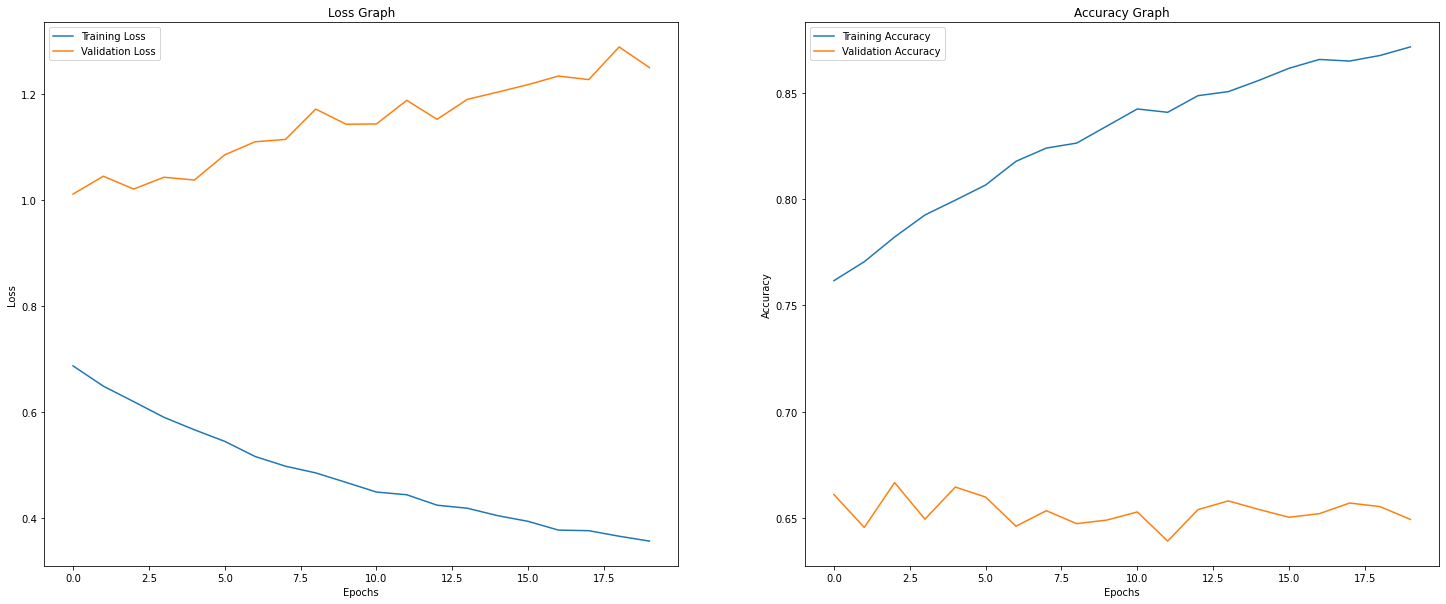

In [6]:
fig, ax = plt.subplots(1,2, figsize=(25,10))

ax[0].plot(result.history["loss"],label="Training Loss")
ax[0].plot(result.history["val_loss"], label="Validation Loss")
ax[0].set_title("Loss Graph")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(result.history["accuracy"],label="Training Accuracy")
ax[1].plot(result.history["val_accuracy"], label="Validation Accuracy")
ax[1].set_title("Accuracy Graph")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show();